Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

In [1]:
import warnings

# 🔵 Disable warnings
warnings.filterwarnings('ignore')

In [65]:
import numpy as np
import tensorflow as tf

# Set reproducible random seed
np.random.seed(123)
tf.random.set_seed(123)

### Importing all the important libraries

In [2]:
import pathlib  # Provides an easy way to work with file system paths
import tensorflow as tf  # TensorFlow is a deep learning framework
import matplotlib.pyplot as plt  # Used for plotting and visualizing data
import numpy as np  # Library for numerical computations
import pandas as pd  # Library for handling data in DataFrame format

# os module helps in interacting with the operating system for file paths, etc.
import os  

# PIL is the Python Imaging Library, used here for handling image files
import PIL

# TensorFlow Keras provides high-level API for building neural networks
from tensorflow import keras  

# Import layers module from Keras to facilitate various building blocks (e.g., Dense, Conv2D)
from tensorflow.keras import layers   

# Sequential is used to build sequential models (a stacked series of layers)
from tensorflow.keras.models import Sequential  

# os ensures interaction with directories or file structures
import os  

# glob is used for finding all the file paths matching a specified pattern
from glob import glob  

# Callbacks for saving models and implementing early stopping criteria
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping  

# Re-import Matplotlib for plotting figures (used implicitly in many scenarios)
import matplotlib.pyplot as plt  

# Seaborn is another visualization library built on top of Matplotlib
import seaborn as sns  

# Commonly used layers in Convolutional Neural Networks (CNN)
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Flatten, Conv2D, Activation, MaxPooling2D, Rescaling  

# Utility function to normalize data (e.g., ensuring RGB pixel values lie between 0 and 1)
from tensorflow.keras.utils import normalize  

# ImageDataGenerator is used for augmenting image data on the fly for training
from tensorflow.keras.preprocessing.image import ImageDataGenerator   

# Import EarlyStopping functionality again (for automatically stopping training if a metric doesn't improve for a given number of epochs)
from tensorflow.keras.callbacks import EarlyStopping

# Import necessary libraries
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import load_model

# At this point, you'd typically start building your model or preparing your dataset.
# The above imports cover essential libraries for building a Convolutional Neural Network (CNN) model, loading data (images), and visualizing results (plotting).


### Importing Skin Cancer Data
#### Uploaded the dataset to kaggle from google drive

In [3]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b0166

### Using my custom Kaggle Dataset in the code

In [4]:
# Defining the path for train and test images
## paths of the train and test dataset
data_dir_train = pathlib.Path("/kaggle/input/av-cnn-melonoma/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/kaggle/input/av-cnn-melonoma/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful `image_dataset_from_directory`utility.

### Create a dataset

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [7]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds=tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                           image_size = (img_height, img_width),
                                                           validation_split = 0.2,
                                                           subset = "training",seed=123,batch_size=32,labels='inferred',
                                                           color_mode = 'rgb',
                                                           shuffle = True)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds=tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                           image_size = (img_height, img_width),
                                                           validation_split = 0.2,
                                                           subset = "validation",seed=123,batch_size=32,labels='inferred',
                                                           color_mode = 'rgb',
                                                           shuffle = True)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [9]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize samples from the training data
#### Code to visualize one instance of all the nine classes present in the dataset

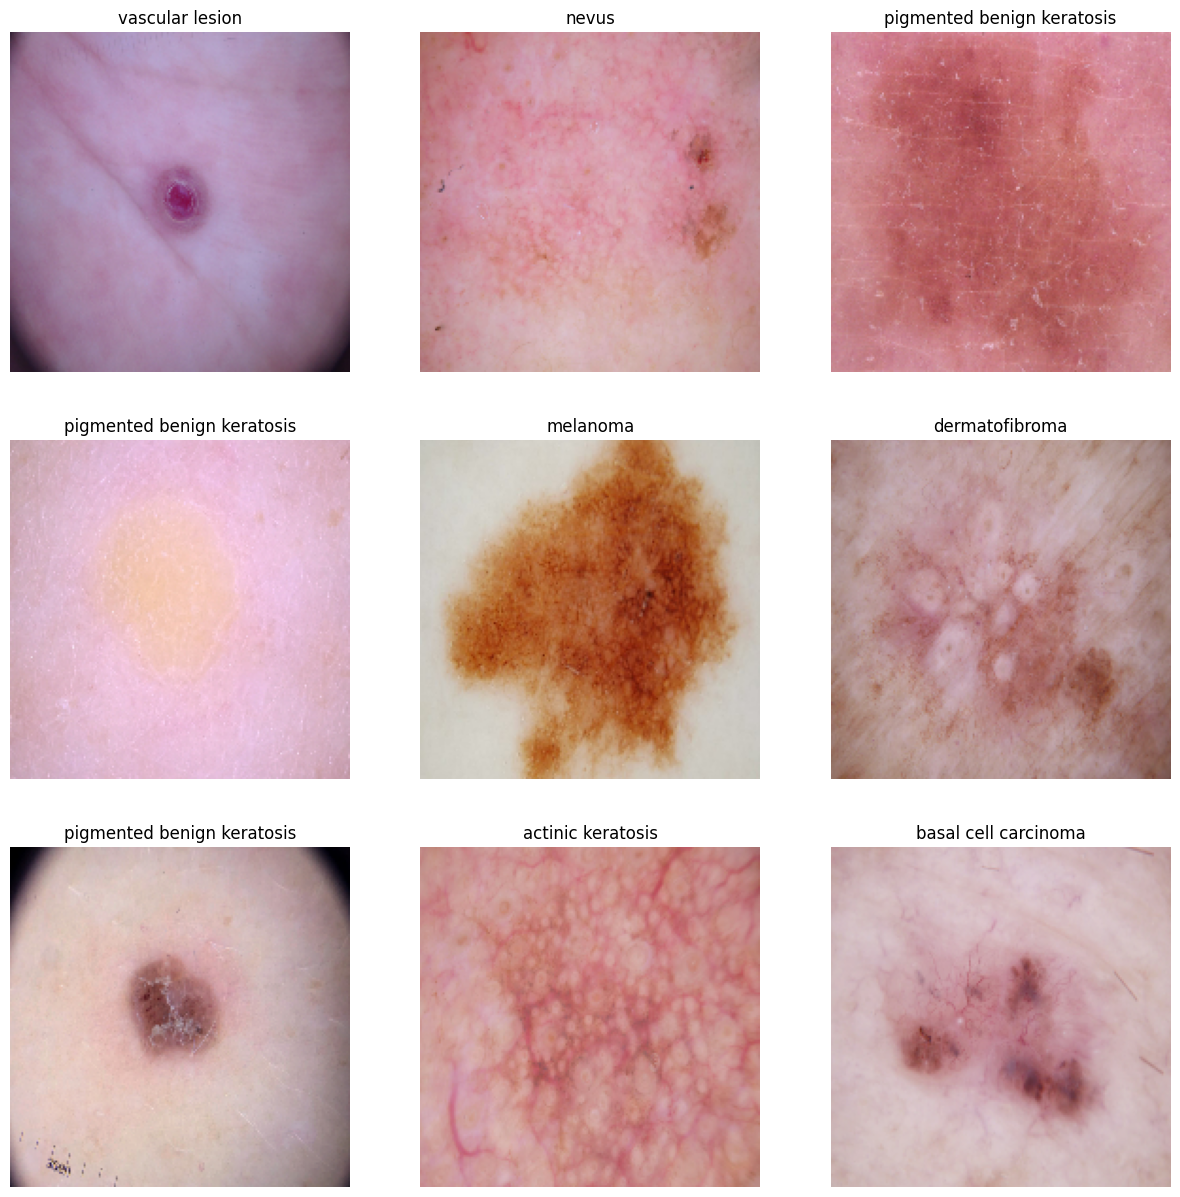

In [10]:
# Fetch a batch of training images and labels
plt.figure(figsize=(15, 15))

for images, labels in train_ds.take(1):  # .take(1) fetches one batch of data
    for i in range(9):  # To visualize 9 classes 
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

plt.show()

#### Util function to count images based on class

In [11]:
def count_images_based_on_class(data_dir):

    count= []
    for path in pathlib.Path(data_dir).iterdir():
        if path.is_dir():

          count.append(len([name for name in os.listdir(path)
                if os.path.isfile(os.path.join(path, name))]))

    #name of the classes
    sub_directory = [name for name in os.listdir(data_dir)
                    if os.path.isdir(os.path.join(data_dir, name))]

    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class_Name', 'Count_of_Images'])

In [12]:
train_df=count_images_based_on_class(data_dir_train)
train_df

,Class_Name,Count_of_Images
0,pigmented benign keratosis,462
1,melanoma,438
2,vascular lesion,139
3,actinic keratosis,114
4,squamous cell carcinoma,181
5,basal cell carcinoma,376
6,seborrheic keratosis,77
7,dermatofibroma,95
8,nevus,357


In [13]:
test_df=count_images_based_on_class(data_dir_test)
test_df

,Class_Name,Count_of_Images
0,pigmented benign keratosis,16
1,melanoma,16
2,vascular lesion,3
3,actinic keratosis,16
4,squamous cell carcinoma,16
5,basal cell carcinoma,16
6,seborrheic keratosis,3
7,dermatofibroma,16
8,nevus,16


#### Finding the distribution of classes in the training dataset.
##### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

Training Data Distribution
Test Data Distribution


<Axes: xlabel='Count_of_Images', ylabel='Class_Name'>

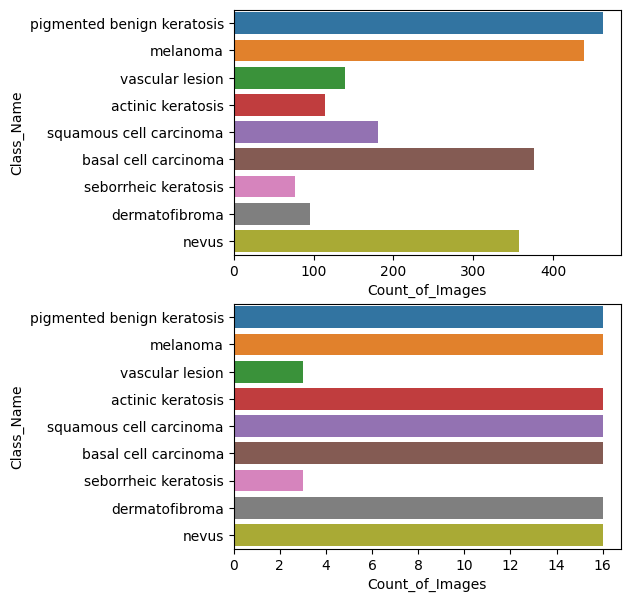

In [14]:

plt.figure(figsize=(5,7))
plt.subplot(2,1,1)
print("Training Data Distribution")
sns.barplot(x="Count_of_Images", y="Class_Name", data=train_df,
            label="Class_Name")
plt.subplot(2,1,2)
print("Test Data Distribution")
sns.barplot(x="Count_of_Images", y="Class_Name", data=test_df,
            label="Class")

####  Observations from Dataset at high level: 
#### - Which class has the least number of samples?

From both charts, it's noticeable that the vascular lesion class has the least number of samples.

Vascular lesion has approximately 90 samples, in the training dataset.
Vascular lesion has approximately 4 samples, in the training dataset, in the testing dataset.

#### - Which classes dominate the data in terms proportionate number of samples?
The classes that dominate the data in terms of the proportionate number of samples are:

* Pigmented benign keratosis
* Melanoma
* Basal cell carcinoma
These three classes have the highest counts in both the training and testing datasets.

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [15]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### CNN model, which can accurately detect 9 classes present in the dataset. Using ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [16]:
input_shape = (180,180,3)
lr = 1e-3
init = 'normal'
activ = 'relu'

model = Sequential()
model.add(Rescaling(1./255, input_shape=(180, 180, 3)))

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(7, 7), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(11, 11), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(512, activation='relu'))

model.add(Dense (9, activation='softmax'))


model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 83, 83, 64)     │       100,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 83, 83, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 41, 41, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 31, 31, 128)    │       991,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 31, 31, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 15, 15, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 28800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    14,746,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         4,617 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,844,169 (60.44 MB)

 Trainable params: 15,843,785 (60.44 MB)

 Non-trainable params: 384 (1.50 KB)

In [17]:
# Multi-class Classification
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  
              metrics=['accuracy'])

### Adding Early Stopping to reduce overfitting

In [18]:
earlystop = EarlyStopping(monitor="val_accuracy",patience=10,mode="auto",verbose=1)


In [19]:
def train_model(model,epochs=10, train_ds=train_ds, valid_ds=val_ds):
    return model.fit(train_ds, validation_data=valid_ds,
                    epochs=epochs,callbacks=[earlystop])


In [20]:
history = train_model(model, 20)

Epoch 1/20


I0000 00:00:1726581715.672408     684 service.cc:145] XLA service 0x58009f0690c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726581715.672456     684 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1726581715.672461     684 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 4/56 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.1615 - loss: 13.5370

I0000 00:00:1726581723.448701     684 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 121ms/step - accuracy: 0.2443 - loss: 19.8495 - val_accuracy: 0.2796 - val_loss: 29.0529
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.3645 - loss: 9.6328 - val_accuracy: 0.1119 - val_loss: 10.2817
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.4144 - loss: 4.8627 - val_accuracy: 0.3915 - val_loss: 9.8068
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.4771 - loss: 3.2884 - val_accuracy: 0.2595 - val_loss: 7.3020
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.5315 - loss: 2.4631 - val_accuracy: 0.2349 - val_loss: 4.7744
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.5786 - loss: 2.0255 - val_accuracy: 0.2774 - val_loss: 30.0495
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.5846 - loss: 1.8485 - val_accuracy: 0.3915 - val_loss: 6.3016
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.6472 - loss: 1.2416 - val_accuracy: 0.2237 - val_lo

In [21]:
len(history.history['accuracy'])

8

### Util function for plotting training accuracy and loss

In [22]:
# def plot_training_history(history, epochs = 10):
#     """
#     Plots the training and validation accuracy/loss for model history.

#     Parameters:
#     - history: the history object from a Keras model after training (history.history attribute should exist)
#     - epochs: the number of epochs used during training (or total epochs to plot)
#     """

#     acc = history.history['accuracy']
#     val_acc = history.history['val_accuracy']

#     loss = history.history['loss']
#     val_loss = history.history['val_loss']

#     # Creating ranges for each epoch
#     epochs_range = range(epochs)

#     # Plotting Training and Validation Accuracy and Loss
#     plt.figure(figsize=(8, 8))

#     # Training and Validation Accuracy (Left Subplot)
#     plt.subplot(1, 2, 1)
#     plt.plot(epochs_range, acc, label='Training Accuracy', linewidth=2, color='lightblue')  # ⬅️ added color
#     plt.plot(epochs_range, val_acc, label='Validation Accuracy', linewidth=2, color='orange')  # ⬅️ added color
#     plt.legend(loc='lower right')
#     plt.title('Training and Validation Accuracy')

#     # Training and Validation Loss (Right Subplot)
#     plt.subplot(1, 2, 2)
#     plt.plot(epochs_range, loss, label='Training Loss', linewidth=2, color='lightgreen')  # ⬅️ added color
#     plt.plot(epochs_range, val_loss, label='Validation Loss', linewidth=2, color='red')  # ⬅️ added color
#     plt.legend(loc='upper right')
#     plt.title('Training and Validation Loss')

#     plt.show()

In [23]:


def plot_training_history(history, epochs=10):
    """
    Plots the training and validation metrics (e.g., accuracy, loss, precision, recall, etc.) 
    for model history.

    Parameters:
    - history: the history object from a Keras model after training (history.history attribute should exist)
    - epochs: the number of epochs used during training (or total epochs to plot)
    """

    # Start by plotting the basic metrics (accuracy and loss)
    acc = history.history.get('accuracy')
    val_acc = history.history.get('val_accuracy')

    loss = history.history.get('loss')
    val_loss = history.history.get('val_loss')

    # Possible additional metrics (check for existence)
    precision = history.history.get('precision')
    val_precision = history.history.get('val_precision')

    recall = history.history.get('recall')
    val_recall = history.history.get('val_recall')

    f1_score = history.history.get('f1_score')
    val_f1_score = history.history.get('val_f1_score')

    # Creating range for the x-axis
    epochs_range = range(epochs)

    plt.figure(figsize=(16, 12))  # Adjusted size for more subplots

    # Plot Accuracy
    if acc and val_acc:
        plt.subplot(3, 2, 1)
        plt.plot(epochs_range, acc, label='Training Accuracy', linewidth=2, color='lightblue')  # Training acc
        plt.plot(epochs_range, val_acc, label='Validation Accuracy', linewidth=2, color='orange')  # Validation acc
        plt.legend(loc='lower right')
        plt.title('Training and Validation Accuracy')

    # Plot Loss
    if loss and val_loss:
        plt.subplot(3, 2, 2)
        plt.plot(epochs_range, loss, label='Training Loss', linewidth=2, color='lightgreen')  # Training loss
        plt.plot(epochs_range, val_loss, label='Validation Loss', linewidth=2, color='red')  # Validation loss
        plt.legend(loc='upper right')
        plt.title('Training and Validation Loss')

    # Plot Precision (if available)
    if precision and val_precision:
        plt.subplot(3, 2, 3)
        plt.plot(epochs_range, precision, label='Training Precision', linewidth=2, color='purple')
        plt.plot(epochs_range, val_precision, label='Validation Precision', linewidth=2, color='yellow')
        plt.legend(loc='lower right')
        plt.title('Training and Validation Precision')

    # Plot Recall (if available)
    if recall and val_recall:
        plt.subplot(3, 2, 4)
        plt.plot(epochs_range, recall, label='Training Recall', linewidth=2, color='lightpink')
        plt.plot(epochs_range, val_recall, label='Validation Recall', linewidth=2, color='orange')
        plt.legend(loc='lower right')
        plt.title('Training and Validation Recall')

    # Plot F1 Score (if available)
    if f1_score and val_f1_score:
        plt.subplot(3, 2, 5)
        plt.plot(epochs_range, f1_score, label='Training F1-Score', linewidth=2, color='lightblue')
        plt.plot(epochs_range, val_f1_score, label='Validation F1-Score', linewidth=2, color='pink')
        plt.legend(loc='lower right')
        plt.title('Training and Validation F1 Score')

    # Tight layout ensures subplots don't overlap
    plt.tight_layout()
    plt.show()

In [24]:
def calculate_metrics(model, train_ds=train_ds, valid_ds = val_ds):
    # Evaluating the model on the training dataset
    loss, accuracy = model.evaluate(train_ds, verbose=1)
    
    # Evaluating the model on the validation dataset
    loss_v, accuracy_v = model.evaluate(valid_ds, verbose=1)

    # Printing accurately with context
    print(f"🔹 **Training Accuracy:** {accuracy * 100:.2f}%")
    print(f"🔹 **Validation Accuracy:** {accuracy_v * 100:.2f}%")
    print(f"🔹 **Training Loss:** {loss:.4f}")
    print(f"🔹 **Validation Loss:** {loss_v:.4f}")

In [25]:
calculate_metrics(model,train_ds, valid_ds=val_ds)

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.2542 - loss: 12.2935
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2510 - loss: 13.1510
🔹 **Training Accuracy:** 26.56%
🔹 **Validation Accuracy:** 22.37%
🔹 **Training Loss:** 12.5778
🔹 **Validation Loss:** 14.2413


### Visualizing training results

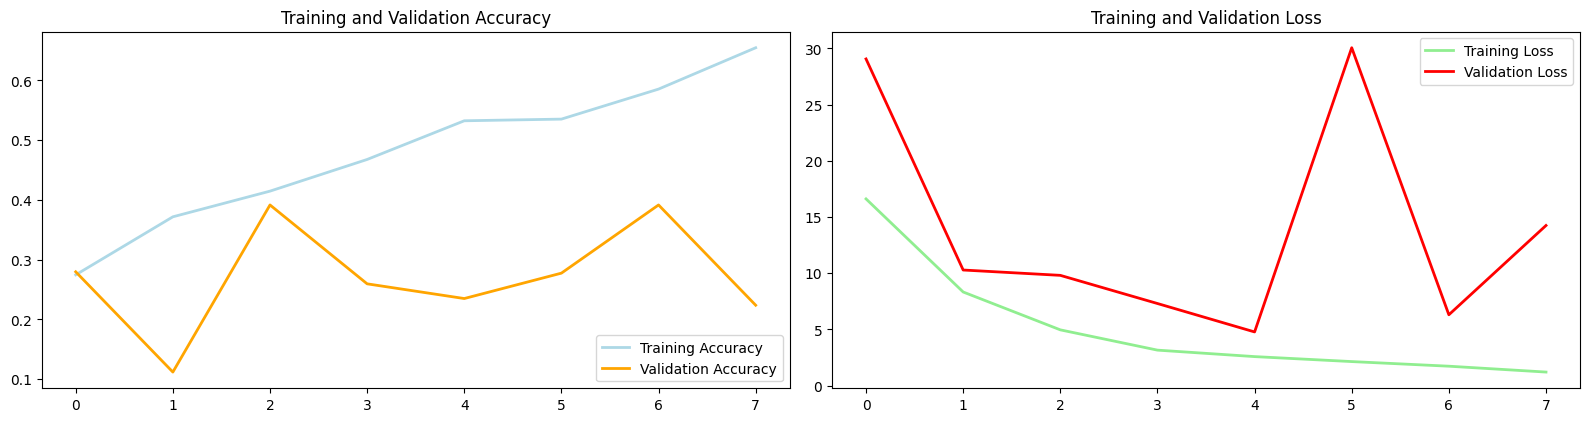

In [26]:
plot_training_history(history, len(history.history['accuracy']))

## Findings after the model fit, that there is an evidence of model overfit or underfit

Training accuracy of the model seems to increase linearly whereas validation accuracy remained stagnant around 55% High training accuracy means the model has learnt the noise in the data as well, however its poor performance on validation data shows lack of generalisability of the model. The above observations confirm the case of overfitting. To mitigate overfitting augmentation technique will be used. Since the training data available is less, we will generate new samples by slightly modifying the existing training data (for eg. flipping the image horizontally/vertically, slightly rotating the image etc) and use them for training the model as well.

#### Analysed the model fit history for presence of underfit or overfit, based on the observations choosing an appropriate data augumentation strategy as discussed below.


Image Data augumented to improve the model performance

In [27]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

In [28]:
training_batches = datagen.flow_from_directory(data_dir_train,
    target_size = (180,180),
    classes = class_names,
    batch_size = 64
 )

validation_batches = datagen.flow_from_directory(data_dir_test,
    target_size = (180,180),
    classes = class_names,
    batch_size = 64
)

Found 2239 images belonging to 9 classes.
Found 118 images belonging to 9 classes.


In [29]:
earlystop = EarlyStopping(monitor="val_accuracy",patience=10,mode="auto",verbose=1)
model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

In [30]:
history = train_model(model, 20, train_ds = training_batches, valid_ds=validation_batches)

Epoch 1/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.4705 - loss: 2.9066 - val_accuracy: 0.1356 - val_loss: 88.7592
Epoch 2/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 40s 956ms/step - accuracy: 0.4609 - loss: 1.7386 - val_accuracy: 0.2542 - val_loss: 10.4320
Epoch 3/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 963ms/step - accuracy: 0.5275 - loss: 1.3522 - val_accuracy: 0.2034 - val_loss: 9.3575
Epoch 4/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 961ms/step - accuracy: 0.5454 - loss: 1.3433 - val_accuracy: 0.1356 - val_loss: 19.7799
Epoch 5/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 40s 948ms/step - accuracy: 0.5520 - loss: 1.2340 - val_accuracy: 0.1610 - val_loss: 10.3922
Epoch 6/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 40s 951ms/step - accuracy: 0.5854 - loss: 1.1821 - val_accuracy: 0.2797 - val_loss: 5.4062
Epoch 7/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 40s 947ms/step - accuracy: 0.5757 - loss: 1.1712 - val_accuracy: 0.3136 - val_loss: 3.5361
Epoch 8/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 40s 943ms/step - accuracy: 0.6224 - loss: 1.0646 - val_acc

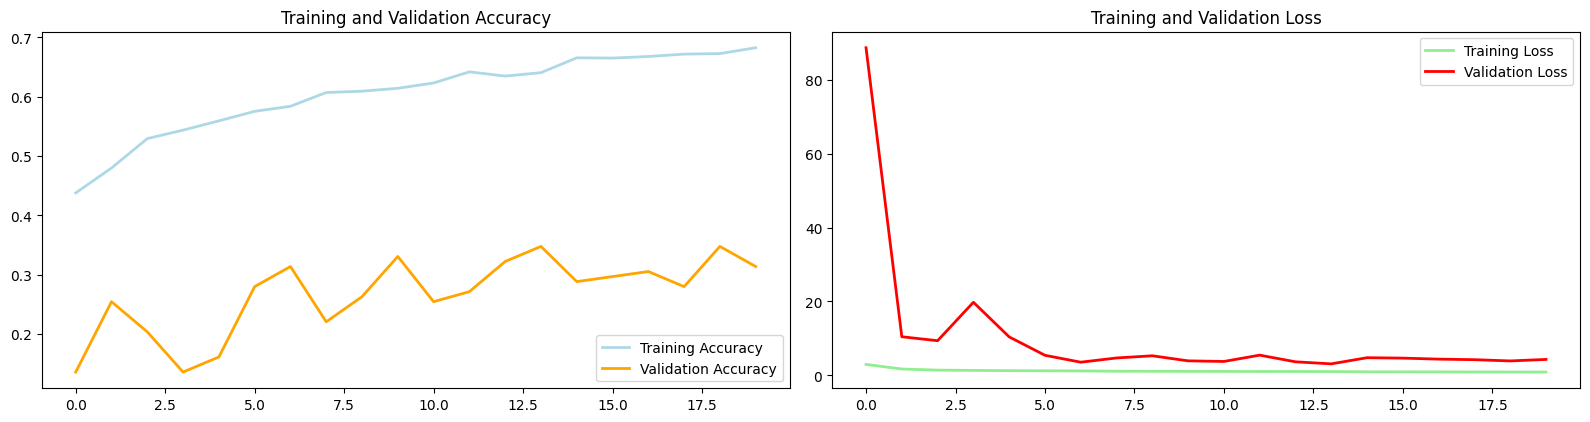

In [31]:
plot_training_history(history, len(history.history['accuracy']))

In [32]:
calculate_metrics(model, train_ds = training_batches, valid_ds=validation_batches)

35/35 ━━━━━━━━━━━━━━━━━━━━ 34s 977ms/step - accuracy: 0.5416 - loss: 1.3608
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.3618 - loss: 4.1782
🔹 **Training Accuracy:** 56.72%
🔹 **Validation Accuracy:** 34.75%
🔹 **Training Loss:** 1.2856
🔹 **Validation Loss:** 4.3240


### Augmentation

Model performance is not improved. So the imbalanced dataset has to be balanced. using augumentations, increasing each class count to 500

### You can use Dropout layer if there is an evidence of overfitting in your findings



In [33]:

input_shape = (180,180,3)
lr = 1e-3
init = 'normal'
activ = 'relu'

model = Sequential()
model.add(Rescaling(1./255, input_shape=(180, 180, 3)))

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(7, 7), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(11, 11), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(512, activation='relu'))

model.add(Dropout(0.5))
model.add(Dense (9, activation='softmax'))
model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 83, 83, 64)     │       100,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 83, 83, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 41, 41, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 31, 31, 128)    │       991,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 31, 31, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 15, 15, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 28800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    14,746,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 9)              │         4,617 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,844,169 (60.44 MB)

 Trainable params: 15,843,785 (60.44 MB)

 Non-trainable params: 384 (1.50 KB)

In [34]:
history = train_model(model, 20, train_ds = training_batches, valid_ds=validation_batches)

Epoch 1/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.2729 - loss: 16.4911 - val_accuracy: 0.1271 - val_loss: 19.2882
Epoch 2/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 40s 945ms/step - accuracy: 0.3388 - loss: 12.3671 - val_accuracy: 0.1271 - val_loss: 11.1700
Epoch 3/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 40s 934ms/step - accuracy: 0.3435 - loss: 8.2319 - val_accuracy: 0.2373 - val_loss: 5.0660
Epoch 4/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 40s 936ms/step - accuracy: 0.3407 - loss: 5.5050 - val_accuracy: 0.2119 - val_loss: 7.3603
Epoch 5/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 40s 928ms/step - accuracy: 0.3599 - loss: 4.2358 - val_accuracy: 0.1356 - val_loss: 9.9962
Epoch 6/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 40s 948ms/step - accuracy: 0.3754 - loss: 3.1474 - val_accuracy: 0.1695 - val_loss: 3.0966
Epoch 7/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 39s 933ms/step - accuracy: 0.3865 - loss: 2.4411 - val_accuracy: 0.1356 - val_loss: 4.2366
Epoch 8/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 40s 925ms/step - accuracy: 0.4271 - loss: 2.0856 - val_acc

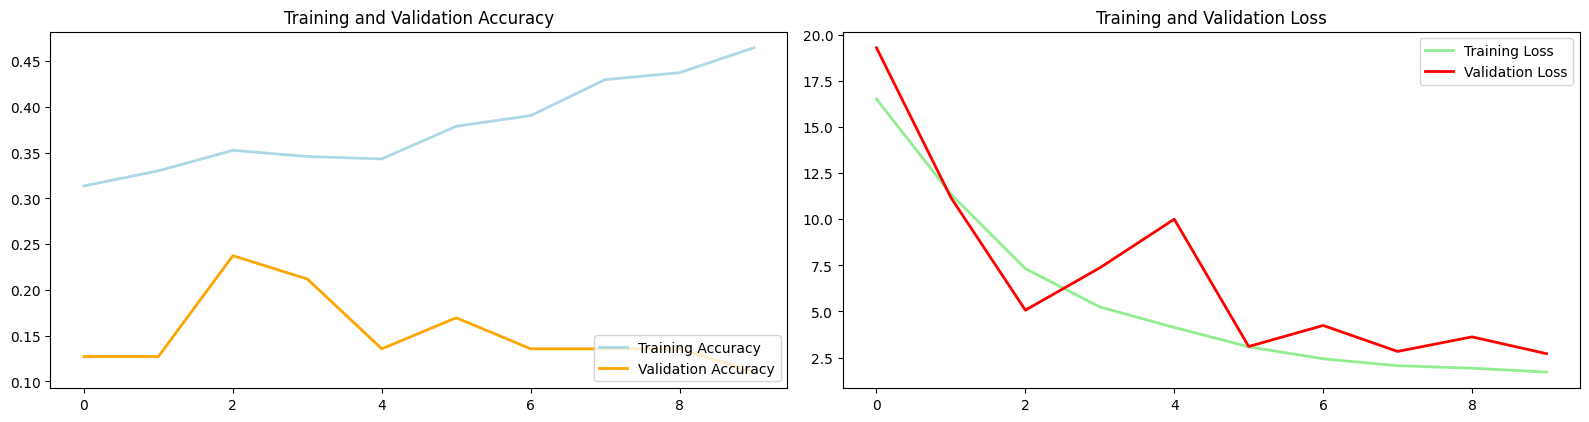

In [35]:
plot_training_history(history, len(history.history['accuracy']))

In [37]:
calculate_metrics(model, train_ds = training_batches, valid_ds=validation_batches)

35/35 ━━━━━━━━━━━━━━━━━━━━ 35s 987ms/step - accuracy: 0.1695 - loss: 2.8421
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.1260 - loss: 2.7194
🔹 **Training Accuracy:** 16.88%
🔹 **Validation Accuracy:** 11.86%
🔹 **Training Loss:** 2.8481
🔹 **Validation Loss:** 2.7091


### Rectifying the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [38]:
!pip install Augmentor

In [39]:
import Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [40]:
!rm -rf "/kaggle/working/augmented_output"

from pathlib import Path  # Import Path if not already imported
import Augmentor

# Assuming data_dir_train is a Path object and a directory containing class folders
path_to_training_dataset = data_dir_train  # Path() automatically handles slashes

# Define a base output directory where augmented files will be stored
output_dir = Path("/kaggle/working/augmented_output")  # Example: '/data/augmented_output'

for i in class_names:
    # Combine the class name with the training data directory
    class_path = path_to_training_dataset / i
    # Combine the class name with the output directory 
    class_output_path = output_dir / i  # Create an output subdirectory for each class

    # Ensure the output subdirectory exists (if not, create it)
    class_output_path.mkdir(parents=True, exist_ok=True)

    # Initialize the Augmentor pipeline
    p = Augmentor.Pipeline(str(class_path), output_directory=str(class_output_path))

    # Define augmentations and sample count
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)  # Add 500 samples per class

Initialised with 114 image(s) found.
Output directory set to /kaggle/working/augmented_output/actinic keratosis.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A4F569DD450>: 100%|██████████| 500/500 [00:06<00:00, 82.74 Samples/s]                   


Initialised with 376 image(s) found.
Output directory set to /kaggle/working/augmented_output/basal cell carcinoma.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A4F14143A30>: 100%|██████████| 500/500 [00:06<00:00, 82.85 Samples/s]                   


Initialised with 95 image(s) found.
Output directory set to /kaggle/working/augmented_output/dermatofibroma.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A4F2EE3C3A0>: 100%|██████████| 500/500 [00:06<00:00, 78.51 Samples/s]                  


Initialised with 438 image(s) found.
Output directory set to /kaggle/working/augmented_output/melanoma.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7A4ECC14AE00>: 100%|██████████| 500/500 [00:37<00:00, 13.35 Samples/s]                   


Initialised with 357 image(s) found.
Output directory set to /kaggle/working/augmented_output/nevus.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7A4EBC213A00>: 100%|██████████| 500/500 [00:29<00:00, 16.88 Samples/s]                   


Initialised with 462 image(s) found.
Output directory set to /kaggle/working/augmented_output/pigmented benign keratosis.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A4EBC37B460>: 100%|██████████| 500/500 [00:05<00:00, 85.45 Samples/s]                   


Initialised with 77 image(s) found.
Output directory set to /kaggle/working/augmented_output/seborrheic keratosis.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7A4EBC256AA0>: 100%|██████████| 500/500 [00:14<00:00, 34.76 Samples/s]                  


Initialised with 181 image(s) found.
Output directory set to /kaggle/working/augmented_output/squamous cell carcinoma.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A4ECC14BF40>: 100%|██████████| 500/500 [00:06<00:00, 82.54 Samples/s]                   


Initialised with 139 image(s) found.
Output directory set to /kaggle/working/augmented_output/vascular lesion.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A4EBC256230>: 100%|██████████| 500/500 [00:06<00:00, 76.14 Samples/s]                  


Augmentor has stored the augmented images in the output sub-directory for each of the sub-directories(labels) of skin cancer types.. 

Lets take a look at total count of augmented images.

In [41]:
image_count_train = len(list(output_dir.glob('*/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [42]:
augmented_ds_path = [x for x in glob(os.path.join('/kaggle/working/', 'augmented_output','**','*.jpg'))]
len(augmented_ds_path)

4500

In [43]:
# Collects the names of folders immediately containing the `.jpg` files
augmented_ds_labels = [
    os.path.basename(os.path.dirname(y)) 
    for y in glob(os.path.join('/kaggle/working/augmented_output', '**', '*.jpg'), recursive=True)
]

# Output the subfolder names
len(augmented_ds_labels)

4500

In [44]:
dataframe_dict = dict(zip(augmented_ds_path, augmented_ds_labels))

In [45]:


balanced_train_df = pd.DataFrame(list(dataframe_dict.items()),columns = ['Path','Label'])
balanced_train_df

,Path,Label
0,/kaggle/working/augmented_output/nevus/nevus_o...,nevus
1,/kaggle/working/augmented_output/nevus/nevus_o...,nevus
2,/kaggle/working/augmented_output/nevus/nevus_o...,nevus
3,/kaggle/working/augmented_output/nevus/nevus_o...,nevus
4,/kaggle/working/augmented_output/nevus/nevus_o...,nevus
...,...,...
4495,/kaggle/working/augmented_output/basal cell ca...,basal cell carcinoma
4496,/kaggle/working/augmented_output/basal cell ca...,basal cell carcinoma
4497,/kaggle/working/augmented_output/basal cell ca...,basal cell carcinoma
4498,/kaggle/working/augmented_output/basal cell ca...,basal cell carcinoma


In [46]:
# Group by the 'Label' column and then count the occurrences of each label.
balanced_train_df_label_counts = balanced_train_df.groupby('Label').size().reset_index(name='Count_of_Images')

# Display the result
balanced_train_df_label_counts

,Label,Count_of_Images
0,actinic keratosis,500
1,basal cell carcinoma,500
2,dermatofibroma,500
3,melanoma,500
4,nevus,500
5,pigmented benign keratosis,500
6,seborrheic keratosis,500
7,squamous cell carcinoma,500
8,vascular lesion,500


Old Training Data Distribution
New Balanced Train Data Distribution


<Axes: xlabel='Count_of_Images', ylabel='Label'>

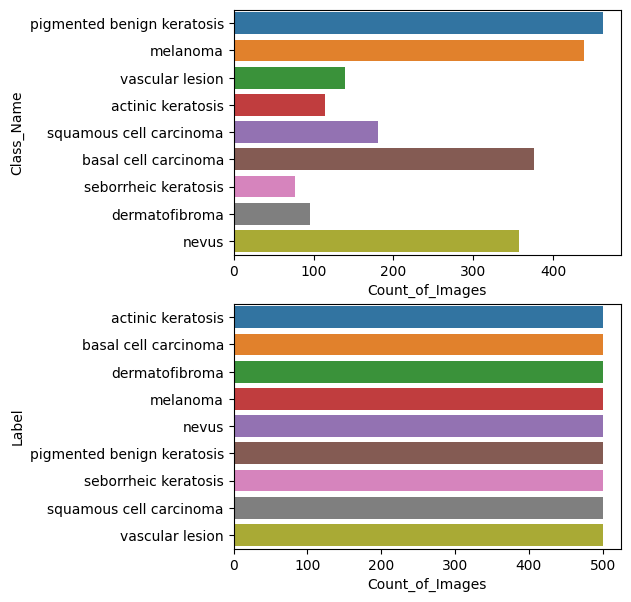

In [47]:

plt.figure(figsize=(5,7))
plt.subplot(2,1,1)
print("Old Training Data Distribution")
sns.barplot(x="Count_of_Images", y="Class_Name", data=train_df,
            label="Label")
plt.subplot(2,1,2)
print("New Balanced Train Data Distribution")
sns.barplot(x="Count_of_Images", y="Label", data=balanced_train_df_label_counts,
            label="Label")

In [48]:
balanced_train_df['Label'].value_counts()

Label
nevus                         500
actinic keratosis             500
squamous cell carcinoma       500
melanoma                      500
pigmented benign keratosis    500
dermatofibroma                500
vascular lesion               500
seborrheic keratosis          500
basal cell carcinoma          500
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Training the model on the data created using Augmentor

In [49]:
batch_size = 32
img_height = 180
img_width = 180

#### Creating a augmented training dataset

In [50]:
#data_dir_train="path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  output_dir,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),label_mode='categorical',
  batch_size=batch_size)

Found 4500 files belonging to 9 classes.
Using 3600 files for training.


#### Creating a augmented dataset

In [51]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  output_dir,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),label_mode='categorical',
  batch_size=batch_size)

Found 4500 files belonging to 9 classes.
Using 900 files for validation.


#### Create your model (make sure to include normalization)

In [52]:
input_shape = (180,180,3)
lr = 1e-4
init = 'normal'
activ = 'relu'

model = Sequential()
model.add(Rescaling(1./255, input_shape=(180, 180, 3)))

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(5, 5), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(512, activation='relu'))

model.add(Dropout(0.25))
model.add(Dense (9, activation='softmax'))

## Since of classes is 9 using softmax
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 87, 87, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 39, 39, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 39, 39, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 19, 19, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 46208)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │    23,659,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 9)              │         4,617 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,888,713 (91.13 MB)

 Trainable params: 23,888,329 (91.13 MB)

 Non-trainable params: 384 (1.50 KB)

#### Compiling the model (using optimizer and loss function appropriately)

In [53]:
## cleanup old checkpoint

In [54]:
!rm "/kaggle/working/model.keras"

rm: cannot remove '/kaggle/working/model.keras': No such file or directory


In [55]:
# Compile the model with optimizer, loss function, and metrics
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Set up the ModelCheckpoint. This saves the best model (with highest validation accuracy).
checkpoint = ModelCheckpoint("/kaggle/working/model.keras", 
                             monitor="val_accuracy", 
                             save_best_only=True, 
                             mode="auto", 
                             verbose=1)

# Set up early stopping, which stops the training when the validation accuracy plateaus.
earlystop = EarlyStopping(monitor="val_accuracy", 
                          patience=10, 
                          mode="auto", 
                          verbose=1)



### Now you can use these callbacks in model.fit()

#### Training the model using checkpoints to capture the progress iteratively

In [57]:
epochs = 40
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs,callbacks=[checkpoint,earlystop])

Epoch 1/40
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.2768 - loss: 26.7651
Epoch 1: val_accuracy improved from -inf to 0.16333, saving model to /kaggle/working/model.keras
113/113 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - accuracy: 0.2773 - loss: 26.7194 - val_accuracy: 0.1633 - val_loss: 13.3175
Epoch 2/40
112/113 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.4233 - loss: 8.5013
Epoch 2: val_accuracy did not improve from 0.16333
113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - accuracy: 0.4235 - loss: 8.4584 - val_accuracy: 0.1011 - val_loss: 9.2968
Epoch 3/40
112/113 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.4809 - loss: 2.4845
Epoch 3: val_accuracy did not improve from 0.16333
113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.4812 - loss: 2.4792 - val_accuracy: 0.1300 - val_loss: 4.3133
Epoch 4/40
112/113 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5753 - loss: 1.4110
Epoch 4: val_accuracy improved from 0.16333 to 0.17222, saving model to /kaggle/working/model

#### **Todo:**  Visualize the model results

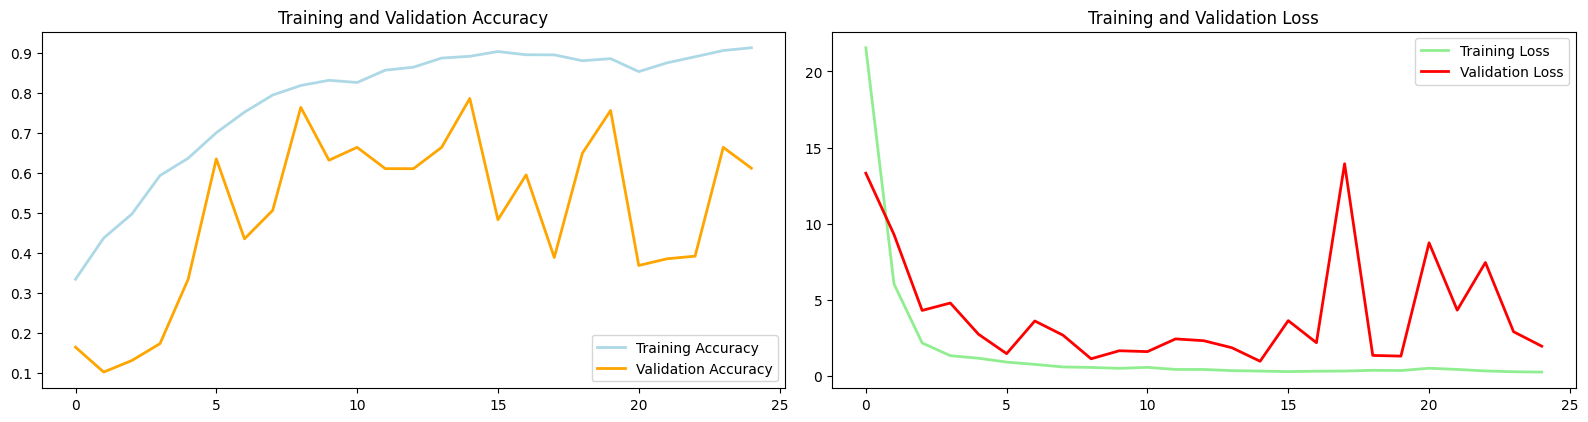

In [58]:
plot_training_history(history, len(history.history['accuracy']))

In [59]:
calculate_metrics(model, train_ds, val_ds)

113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.7526 - loss: 0.9726
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.6115 - loss: 2.0441
🔹 **Training Accuracy:** 76.31%
🔹 **Validation Accuracy:** 61.11%
🔹 **Training Loss:** 0.9140
🔹 **Validation Loss:** 1.9676


#### Analysis of the results here. Did we get rid of underfitting/overfitting? Did class rebalance help us?



### Vizualizing how our augmentation strategy works for one instance of training image.

In [60]:
## Identify a image from test data for the given class

In [61]:

class_names=os.listdir(data_dir_test)
class_num=2
Test_image_path = os.path.join(pathlib.Path(data_dir_test), class_names[class_num], '*')
Test_image_path




'/kaggle/input/av-cnn-melonoma/Skin cancer ISIC The International Skin Imaging Collaboration/Test/vascular lesion/*'

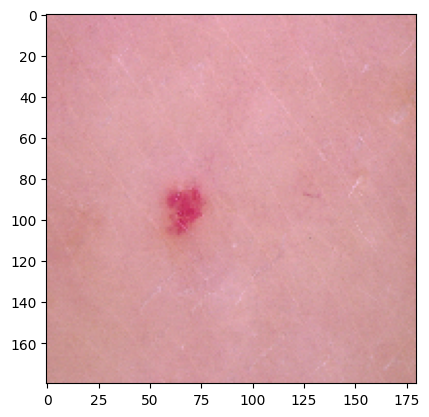

In [62]:
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)

### Predicting using the model on the test data

In [70]:
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[class_num] +'\n'+ "Predictive Class "+pred_class )

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Actual Class vascular lesion
Predictive Class melanoma


In [71]:
# Load the saved model (Architecture + Weights). 
# Assume your model checkpoint is saved as 'model_checkpoint.h5'
checkpoint_model = load_model('/kaggle/working/model.keras')

# Assuming you have a preprocessed image (img) in a format that your model accepts:
# Feed the image to the model.
pred_new = checkpoint_model.predict(img)
pred = np.argmax(pred_new)
pred_class = class_names[pred]
print("Actual Class "+ class_names[class_num] +'\n'+ "Predictive Class "+pred_class )

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
Actual Class vascular lesion
Predictive Class melanoma
